# 5. Application

In [ ]:
This Titanic project was made at Miuul Machine Learning Summer BootCamp with narration by Vahit Keskin.

**TABLE OF CONTENTS**

- [Import Libraries](#51-import-libraries)
- [Data Loading](#52-data-loading)
- [Feature Engineering & Data Preprocessing](#53-feature-engineering--data-preprocessing)
- [Handling Outliers](#54-handling-outliers)
- [Handling Missing Values](#55-handling-missing-values)
- [Label Encoding](#56-label-encoding)
- [Rare Encoding](#57-rare-encoding)
- [One-Hot Encoding](#58-one-hot-encoding)
- [Standard Scaler Processing](#59-standard-scaler-processing)
- [Modelling](#510-modelling)

## 5.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

## 5.2 Data Loading

In [3]:
# Data set for small scale application
def load_titanic():
    data = pd.read_csv("datasets/titanic.csv")
    return data


df = load_titanic()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [4]:
df.shape

(891, 12)

In [5]:
df.columns = [col.upper() for col in df.columns]
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


### 5.2.1 Auto Find Categorical / Numerical / Cardinal / Nominal / Ordinal Features

In [6]:
def grab_col_names(dataframe, categorical_threshold = 10, cardinal_threshold= 20):
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables but numerical variables are also included in categorical variables.

    Parameters
    ----------
    dataframe : dataframe
        The dataframe from which variables names are to be retrieved.
    categorical_threshold : int, optional
        class threshold for numeric but categorical variables
    cardinal_threshold : int, optional
        Class threshold for categorical but cardinal variables

    Returns
    -------
        categorical_cols : list
            Categorical variable list
        numerical_cols : list
            Numerical variable list
        cardinal_cols : list
            Categorical looking cardinal variable list

    Examples
    -------
        import seaborn as sns
        df = sns.load_titanic_dataset("iris")
        print(grab_col_names(df))

    Notes
    -------
        categorical_cols + numerical_cols + cardinal_cols = total number of variables.
        nominal_cols is inside categorical_cols
        The sum of the 3 returned lists equals the total number of variables: categorical_cols + cardinal_cols = number of variables

    """

    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    nominal_cols = [col for col in dataframe.columns if dataframe[col].nunique() < categorical_threshold and dataframe[col].dtypes != "O"]
    cardinal_cols = [col for col in dataframe.columns if dataframe[col].nunique() > cardinal_threshold and dataframe[col].dtypes == "O"]
    categorical_cols = categorical_cols + nominal_cols
    categorical_cols = [col for col in categorical_cols if col not in cardinal_cols]

    # numerical_cols
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorical_cols: {len(categorical_cols)}')
    print(f'numerical_cols: {len(numerical_cols)}')
    print(f'cardinal_cols: {len(cardinal_cols)}')
    print(f'nominal_cols: {len(nominal_cols)}')
    return categorical_cols, numerical_cols, cardinal_cols, nominal_cols

In [7]:
categorical_cols, numerical_cols, cardinal_cols,nominal_cols = grab_col_names(df)
numerical_cols = [col for col in numerical_cols if "PASSENGERID" not in col]

Observations: 891
Variables: 12
categorical_cols: 6
numerical_cols: 3
cardinal_cols: 3
nominal_cols: 4


## 5.3 Feature Engineering & Data Preprocessing

In [8]:
# Cabin bool
df["NEW_CABIN_BOOL"] = df["CABIN"].notnull().astype('int64')

In [9]:
# Name count
df["NEW_NAME_COUNT"] = df["NAME"].str.len()

In [10]:
# name word count
df["NEW_NAME_WORD_COUNT"] = df["NAME"].apply(lambda x: len(str(x).split(" ")))

In [11]:
# name dr
df["NEW_NAME_DR"] = df["NAME"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

In [12]:
# name title
df['NEW_TITLE'] = df.NAME.str.extract(' ([A-Za-z]+)\.', expand=False)

In [13]:
# family size
df["NEW_FAMILY_SIZE"] = df["SIBSP"] + df["PARCH"] + 1

In [14]:
# age_pclass
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [15]:
# is alone
df.loc[((df['SIBSP'] + df['PARCH']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SIBSP'] + df['PARCH']) == 0), "NEW_IS_ALONE"] = "YES"

In [16]:
# age level
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [17]:
# sex x age
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [18]:
df.head()

,PASSENGERID,SURVIVED,PCLASS,NAME,SEX,AGE,SIBSP,PARCH,TICKET,FARE,CABIN,EMBARKED,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE,NEW_FAMILY_SIZE,NEW_AGE_PCLASS,NEW_IS_ALONE,NEW_AGE_CAT,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,23,4,0,Mr,2,66.000,NO,mature,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,51,7,0,Mrs,2,38.000,NO,mature,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,22,3,0,Miss,1,78.000,YES,mature,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,44,7,0,Mrs,2,35.000,NO,mature,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,24,4,0,Mr,1,105.000,YES,mature,maturemale


In [19]:
df.shape

(891, 22)

In [20]:
categorical_cols, numerical_cols, cardinal_cols,nominal_cols = grab_col_names(df)
numerical_cols = [col for col in numerical_cols if "PASSENGERID" not in col]

Observations: 891
Variables: 22
categorical_cols: 14
numerical_cols: 5
cardinal_cols: 3
nominal_cols: 8


## 5.4 Handling Outliers

### 5.4.1 Outlier Thresholds

In [21]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + (1.5 * interquartile_range)
    low_limit = quartile1 - (1.5 * interquartile_range)
    return low_limit, up_limit

### 5.4.2 Check Outliers

In [22]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

### 5.4.3 Replace the low, up limit with Thresholds

In [23]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

### 5.4.4 Checking if Outlier is Cleared

In [24]:
for col in numerical_cols:
    print(col, check_outlier(df, col))

AGE True
FARE True
NEW_NAME_COUNT True
NEW_AGE_PCLASS True


In [25]:
for col in numerical_cols:
    replace_with_thresholds(df, col)

In [26]:
for col in numerical_cols:
    print(col, check_outlier(df, col))

AGE False
FARE False
NEW_NAME_COUNT False
NEW_AGE_PCLASS False


## 5.5 Handling Missing Values

In [27]:
def missing_values_table(dataframe, na_name=False):
    
    # Column Names with Missing Values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    # Number of Missing Values of One Column
    number_of_missing_values = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    
    # Percentage Distribution of Missing Data
    percentage_ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    # Dataframe with Missing Data
    missing_df = pd.concat([number_of_missing_values, np.round(percentage_ratio, 2)], axis=1, keys=['number_of_missing_values', 'percentage_ratio'])
    
    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [28]:
missing_values_table(df)

                number_of_missing_values  percentage_ratio
CABIN                                687            77.100
AGE                                  177            19.870
NEW_AGE_PCLASS                       177            19.870
NEW_AGE_CAT                          177            19.870
NEW_SEX_CAT                          177            19.870
EMBARKED                               2             0.220


In [29]:
df.drop("CABIN", inplace=True, axis=1)

In [30]:
remove_cols = ["TICKET", "NAME"]
df.drop(remove_cols, inplace=True, axis=1)

In [31]:
df["AGE"] = df["AGE"].fillna(df.groupby("NEW_TITLE")["AGE"].transform("median"))

In [32]:
missing_values_table(df)

                number_of_missing_values  percentage_ratio
NEW_AGE_PCLASS                       177            19.870
NEW_AGE_CAT                          177            19.870
NEW_SEX_CAT                          177            19.870
EMBARKED                               2             0.220


In [33]:
df["NEW_AGE_PCLASS"] = df["AGE"] * df["PCLASS"]

In [34]:
df.loc[(df['AGE'] < 18), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['AGE'] >= 18) & (df['AGE'] < 56), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['AGE'] >= 56), 'NEW_AGE_CAT'] = 'senior'

In [35]:
df.loc[(df['SEX'] == 'male') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturemale'
df.loc[(df['SEX'] == 'male') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] > 21) & (df['AGE'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'
df.loc[(df['SEX'] == 'female') & (df['AGE'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [36]:
missing_values_table(df)

          number_of_missing_values  percentage_ratio
EMBARKED                         2             0.220


In [37]:
df = df.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= 10) else x, axis=0)

In [38]:
missing_values_table(df) # Handling Missing Values is done.

Empty DataFrame
Columns: [number_of_missing_values, percentage_ratio]
Index: []


## 5.6 Label Encoding

In [39]:
binary_cols = [col for col in df.columns if df[col].dtype not in ["int64", "float64"]
               and df[col].nunique() == 2]

In [40]:
binary_cols

['SEX', 'NEW_IS_ALONE']

In [41]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [42]:
for col in binary_cols:
    df = label_encoder(df, col)

## 5.7 Rare Encoding

In [43]:
def rare_analyser(dataframe, target, cat_cols):
    for col in categorical_cols:
        print(col,":",len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [44]:
rare_analyser(df, "SURVIVED", categorical_cols)

SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


EMBARKED : 3
   COUNT  RATIO  TARGET_MEAN
C    168  0.189        0.554
Q     77  0.086        0.390
S    646  0.725        0.339


NEW_TITLE : 17
          COUNT  RATIO  TARGET_MEAN
Capt          1  0.001        0.000
Col           2  0.002        0.500
Countess      1  0.001        1.000
Don           1  0.001        0.000
Dr            7  0.008        0.429
Jonkheer      1  0.001        0.000
Lady          1  0.001        1.000
Major         2  0.002        0.500
Master       40  0.045        0.575
Miss        182  0.204        0.698
Mlle          2  0.002        1.000
Mme           1  0.001        1.000
Mr          517  0.580        0.157
Mrs         125  0.140        0.792
Ms            1  0.001        1.000
Rev           6  0.007        0.000
Sir           1  0.001        1.000


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


N

In [45]:
def rare_encoder(dataframe, rare_percentage):
    temp_df = dataframe.copy()
    
    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O" and
                    (temp_df[col].value_counts() / len(temp_df) < rare_percentage).any(axis=None)]
    
    for variable in rare_columns:
        tmp = temp_df[variable].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_percentage].index
        temp_df[variable] = np.where(temp_df[variable].isin(rare_labels), 'Rare', temp_df[variable])

    return temp_df

In [46]:
df = rare_encoder(df, 0.01)

In [47]:
df["NEW_TITLE"].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: NEW_TITLE, dtype: int64

## 5.8 One Hot Encoding

In [48]:
one_hot_encoding_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
one_hot_encoding_cols

['PCLASS',
 'SIBSP',
 'PARCH',
 'EMBARKED',
 'NEW_NAME_WORD_COUNT',
 'NEW_TITLE',
 'NEW_FAMILY_SIZE',
 'NEW_AGE_CAT',
 'NEW_SEX_CAT']

In [49]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, one_hot_encoding_cols)
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,22.000,7.250,0,23,0,66.000,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2,1,0,38.000,65.634,1,45,0,38.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3,1,0,26.000,7.925,0,22,0,78.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,4,1,0,35.000,53.100,1,44,0,35.000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,5,0,1,35.000,8.050,0,24,0,105.000,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [50]:
df.shape

(891, 61)

In [51]:
categorical_cols, numerical_cols, cardinal_cols,nominal_cols = grab_col_names(df)

Observations: 891
Variables: 61
categorical_cols: 56
numerical_cols: 5
cardinal_cols: 0
nominal_cols: 56


In [52]:
numerical_cols = [col for col in numerical_cols if "PASSENGERID" not in col]

In [53]:
numerical_cols

['AGE', 'FARE', 'NEW_NAME_COUNT', 'NEW_AGE_PCLASS']

In [54]:
rare_analyser(df, "SURVIVED", categorical_cols)

SURVIVED : 2
   COUNT  RATIO  TARGET_MEAN
0    549  0.616        0.000
1    342  0.384        1.000


SEX : 2
   COUNT  RATIO  TARGET_MEAN
0    314  0.352        0.742
1    577  0.648        0.189


NEW_CABIN_BOOL : 2
   COUNT  RATIO  TARGET_MEAN
0    687  0.771        0.300
1    204  0.229        0.667


NEW_NAME_DR : 2
   COUNT  RATIO  TARGET_MEAN
0    881  0.989        0.383
1     10  0.011        0.500


NEW_IS_ALONE : 2
   COUNT  RATIO  TARGET_MEAN
0    354  0.397        0.506
1    537  0.603        0.304


PCLASS_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    675  0.758        0.305
1    216  0.242        0.630


PCLASS_2 : 2
   COUNT  RATIO  TARGET_MEAN
0    707  0.793        0.361
1    184  0.207        0.473


PCLASS_3 : 2
   COUNT  RATIO  TARGET_MEAN
0    400  0.449        0.557
1    491  0.551        0.242


SIBSP_0 : 2
   COUNT  RATIO  TARGET_MEAN
0    283  0.318        0.466
1    608  0.682        0.345


SIBSP_1 : 2
   COUNT  RATIO  TARGET_MEAN
0    682  0.765        0.337
1    

In [55]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

useless_cols

['SIBSP_5',
 'SIBSP_8',
 'PARCH_3',
 'PARCH_4',
 'PARCH_5',
 'PARCH_6',
 'NEW_NAME_WORD_COUNT_9',
 'NEW_NAME_WORD_COUNT_14',
 'NEW_FAMILY_SIZE_8',
 'NEW_FAMILY_SIZE_11']

In [56]:
#df.drop(useless_cols, axis=1, inplace=True)

## 5.9 Standard Scaler Processing

In [57]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df[numerical_cols].head()

,AGE,FARE,NEW_NAME_COUNT,NEW_AGE_PCLASS
0,-0.561,-0.821,-0.437,0.066
1,0.663,2.032,2.248,-0.790
2,-0.255,-0.788,-0.559,0.434
3,0.434,1.419,2.126,-0.882
4,0.434,-0.781,-0.315,1.260


In [58]:
df.head()

,PASSENGERID,SURVIVED,SEX,AGE,FARE,NEW_CABIN_BOOL,NEW_NAME_COUNT,NEW_NAME_DR,NEW_AGE_PCLASS,NEW_IS_ALONE,PCLASS_1,PCLASS_2,PCLASS_3,SIBSP_0,SIBSP_1,SIBSP_2,SIBSP_3,SIBSP_4,SIBSP_5,SIBSP_8,PARCH_0,PARCH_1,PARCH_2,PARCH_3,PARCH_4,PARCH_5,PARCH_6,EMBARKED_C,EMBARKED_Q,EMBARKED_S,NEW_NAME_WORD_COUNT_3,NEW_NAME_WORD_COUNT_4,NEW_NAME_WORD_COUNT_5,NEW_NAME_WORD_COUNT_6,NEW_NAME_WORD_COUNT_7,NEW_NAME_WORD_COUNT_8,NEW_NAME_WORD_COUNT_9,NEW_NAME_WORD_COUNT_14,NEW_TITLE_Master,NEW_TITLE_Miss,NEW_TITLE_Mr,NEW_TITLE_Mrs,NEW_TITLE_Rare,NEW_FAMILY_SIZE_1,NEW_FAMILY_SIZE_2,NEW_FAMILY_SIZE_3,NEW_FAMILY_SIZE_4,NEW_FAMILY_SIZE_5,NEW_FAMILY_SIZE_6,NEW_FAMILY_SIZE_7,NEW_FAMILY_SIZE_8,NEW_FAMILY_SIZE_11,NEW_AGE_CAT_mature,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NEW_SEX_CAT_maturefemale,NEW_SEX_CAT_maturemale,NEW_SEX_CAT_seniorfemale,NEW_SEX_CAT_seniormale,NEW_SEX_CAT_youngfemale,NEW_SEX_CAT_youngmale
0,1,0,1,-0.561,-0.821,0,-0.437,0,0.066,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
1,2,1,0,0.663,2.032,1,2.248,0,-0.790,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,3,1,0,-0.255,-0.788,0,-0.559,0,0.434,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
3,4,1,0,0.434,1.419,1,2.126,0,-0.882,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,5,0,1,0.434,-0.781,0,-0.315,0,1.260,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [63]:
df.shape

(891, 61)

## 5.10 Modelling

In [59]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [60]:
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
auc_after_feature_engineering = accuracy_score(y_pred, y_test)

In [61]:
print('AUC Score After Feature Engineering={:.3f}%'.format((auc_after_feature_engineering)*100))

AUC Score After Feature Engineering=80.597%


### 5.10.1 The score to be obtained without any action

In [62]:
dff = load_titanic()
dff.dropna(inplace=True) # Random Forest doesn't work for NaN values in this dataset.
dff = pd.get_dummies(dff, columns=["Sex", "Embarked"], drop_first=True) # Random Forest doesn't work without feature engineering in this dataset.
y = dff["Survived"]
X = dff.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

auc_without_any_action = accuracy_score(y_pred, y_test)


In [63]:
print('AUC Score Without Any Action={:.3f}%'.format((auc_without_any_action)*100))

AUC Score Without Any Action=70.909%


### 5.10.2 What about the variables we just produced?

In [64]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


In [67]:
y = df["SURVIVED"]
X = df.drop(["PASSENGERID", "SURVIVED"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.8059701492537313

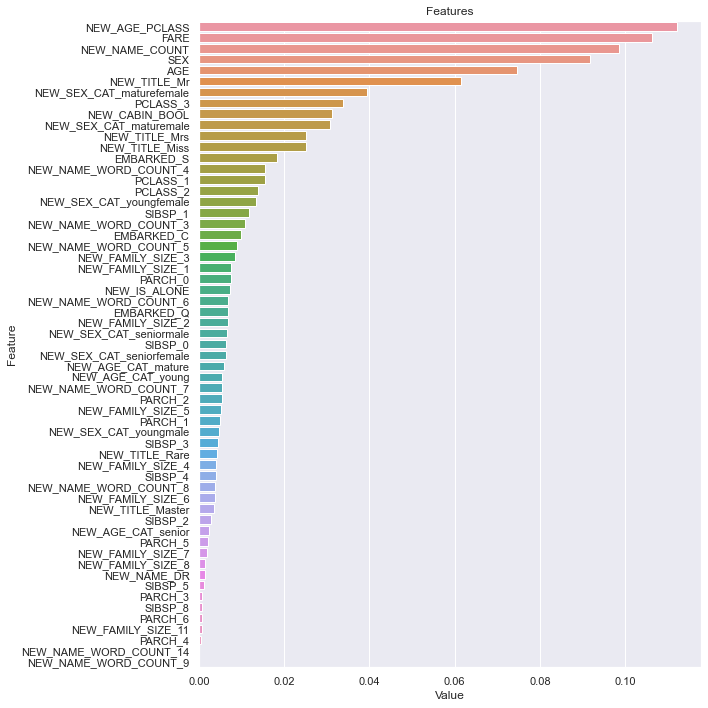

In [68]:
plot_importance(rf_model, X_train)